In [1]:
## Generally setup

import numpy as np
import os.path as op
import os
import matplotlib.pyplot as plt
from langouEEG import *
from scipy.stats import *
from eeg_microstates3 import *
import pandas as pd
import time

import mne
import pickle
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity, envelope_correlation
from mne.viz import circular_layout, plot_connectivity_circle
import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.minimum_norm import write_inverse_operator
from mne.viz import plot_topomap

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne

sample_data_folder = mne.datasets.sample.data_path()
dataRoot = "/data/home/viscent/Light"
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = False
isAll = True
isBlind = False
if not isAll:
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
else:
    result_dir = op.join(dataRoot,'result','all')
if isBlind:
    result_dir = op.join(result_dir,'Blind')
subjects_dir = op.dirname(fs_dir)
if not op.exists(result_dir):
    os.mkdir(result_dir)
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
print(__doc__)

0 files missing from root.txt in /data/home/viscent/freesurfer/subjects
0 files missing from bem.txt in /data/home/viscent/freesurfer/subjects/fsaverage
Automatically created module for IPython interactive environment


In [2]:
## Input EEG data and extarct epochs

epochs_4F = dict()
epochs_RF = dict()
epochs_4R = dict()
epochs_RR = dict()

tmin_rest, tmax_rest, tmin_flick,tmax_flick = 40, 60, 10, 30
tmin_R_flick, tmax_R_flick = 10, 15

for subject_name in range(1,21):
    if not isAll:
        if not (isMale ^ (subject_name in [7,8,11,17])):
            continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data_av/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')
    if isBlind:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochsBlind(raw,events,picks, 
        tmin_rest = 60,tmax_rest = 87,tmin_flick = 3,tmax_flick = 30)
    else:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs_id(raw,events,picks, 
        tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_flick,tmax_flick = tmax_flick)
        _,epoch_RF,_,_ = extractEpochs_id(raw,events,picks, 
        tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_R_flick,tmax_flick = tmax_R_flick)
    epochs_4F[subject_name]=epoch_4F
    epochs_RF[subject_name]=epoch_RF
    epochs_RR[subject_name]=epoch_RR
    epochs_4R[subject_name]=epoch_4R
    if not op.exists(os.path.join(dataRoot,'fwd_solution.lgeeg')):
        fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                        bem=bem, eeg=True, mindist=5.0, n_jobs=1)
        print(fwd)
        mne.write_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'),fwd,overwrite=True)
    else:
        fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))
    data_path = sample.data_path()

    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')

## Concact epochs
epoch_4F = mne.concatenate_epochs(list(epochs_4F.values()))
epoch_RF = mne.concatenate_epochs(list(epochs_RF.values()))
epoch_4R = mne.concatenate_epochs(list(epochs_4R.values()))

Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '255', '8', '9']
{'11': 1, '12': 2, '255': 3, '8': 4, '9': 5}
Used Annotations descriptions: ['11', '12', '255', '8', '9']
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 4 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 4 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matchin

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 3 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
4 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '255', '8', '9']
{'11': 1, '12': 2, '255': 3, '8': 4, '9': 5}
Used Annotations descriptions: ['11', '12', '255', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matchin

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 8 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 9 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
9 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Used Annotations descriptions: ['11', '12', '8', '9']
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying 

/tmp/ipykernel_30186/3184131707.py:42: RuntimeWarning: This filename (/data/home/viscent/Light/fwd_solution.lgeeg) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))


Not setting metadata
Not setting metadata
102 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Not setting metadata
Not setting metadata
95 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Not setting metadata
Not setting metadata
105 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


In [3]:
result_dir = "/data/home/viscent/Light/result/microstates"
tm = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
time_augs=[tmin_rest, tmax_rest, tmin_flick, tmax_flick, tmin_R_flick, tmax_R_flick]

def plot_substate(epoch, maps, n_maps, dpi=300, save=False, filename='Default', fmt='.png'):
    fig, axis = plt.subplots(1, n_maps, dpi=dpi)
    for i in range(0,n_maps):
        axis[i].set_title('state{0}'.format(i+1))
        plot_topomap(maps[i], epoch.info, axes=axis[i], show=False)
    fig.show()
    if save:
        fig.savefig(result_dir + '/' + filename + fmt)
    return fig

def display_gfp_peaks(gfp_peaks, x, fs):
    pps = len(gfp_peaks) / (len(x)/fs)  # peaks per second
    print(f"\nGFP peaks per sec.: {pps:.2f}")
    return

def display_gev(gev):
    print("\nGlobal explained variance (GEV) per map:")
    for i, g in enumerate(gev): print(f"GEV(ms-{i:d}) = {gev[i]:.2f}")
    print(f"\ntotal GEV: {gev.sum():.3f}")
    return

def display_info(x, n_maps, gfp_peaks, gev, fs):
    p_hat = p_empirical(x, n_maps)
    T_hat = T_empirical(x, n_maps)
    print("\nEmpirical symbol distribution (RTT):\n")
    for i in range(n_maps):
        print(f"p_{i:d} = {p_hat[i]:.3f}")
    print("\nEmpirical transition matrix:\n")
    print_matrix(T_hat)

    display_gfp_peaks(gfp_peaks=gfp_peaks,x=x, fs=fs)
    display_gev(gev)

    h_hat = H_1(x, n_maps)
    h_max = max_entropy(n_maps)
    print(f"\nEmpirical entropy H = {h_hat:.2f} (max. entropy: {h_max:.2f})")
    h_rate, _ = excess_entropy_rate(x, n_maps, kmax=8, doplot=True)
    h_mc = mc_entropy_rate(p_hat, T_hat)
    print(f"\nEmpirical entropy rate h = {h_rate:.2f}")
    print(f"Theoretical MC entropy rate h = {h_mc:.2f}")
    return

def display_states(x, pca1):
    fig, ax = plt.subplots(2, 1, figsize=(15,4), sharex=True)
    ax[0].plot(x[0:3000])
    ax[1].plot(pca1[0:3000])
    return

def save_to_file(array, filepath):
    np.asarray(array)
    df = pd.DataFrame (array)
    df.to_csv(filepath, index=False)
    return 

def save_cache(folder_path, x, maps, pca, gfp_peaks, gev, state, fig, time_augs, fmt='.png'):
    if not os.path.exists(folder_path):  #判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(folder_path)
    save_to_file(time_augs,  folder_path + '/4R4R4F4FRFRF_time.csv')
    save_to_file(x, folder_path + '/x_{0}.csv'.format(state))
    save_to_file(maps, folder_path + '/maps_{0}.csv'.format(state))
    save_to_file(pca, folder_path + '/pca_{0}.csv'.format(state))
    save_to_file(gfp_peaks, folder_path + '/gfp_peaks_{0}.csv'.format(state))
    save_to_file(gev, folder_path + '/gev_{0}.csv'.format(state))
    fig.savefig(folder_path + '/' + state + fmt)
    return

def display_maps(epoch, tm, n_maps=4, save=False, dpi=300, filename='Default', fmt='.png', to_save_cache=False, time_augs=[0,0,0,0]):
    data_raw = np.hstack(epoch.get_data()).T
    fs = 500
    data = bp_filter(data_raw, f_lo=2, f_hi=20, fs=fs)
    print(data.shape)
    pca = PCA(copy=True, n_components=1, whiten=False)
    pca1 = pca.fit_transform(data)[:,0]

    plot_data(pca1, fs)
    t0, t1 = 1000, 3000
    plot_data(pca1[t0:t1], fs)
    mode = ["aahc", "kmeans", "kmedoids", "pca", "ica"][1]
    print(f"Clustering algorithm: {mode:s}")
    n_maps = n_maps
    chs = 64
    locs = []
    maps, x, gfp_peaks, gev = clustering(data, fs, chs, locs, mode, n_maps, interpol=False, doplot=False)
    display_info(x, n_maps, gfp_peaks, gev, fs)
    display_states(x, pca1)
    fig = plot_substate(epoch=epoch, maps=maps, n_maps=n_maps, save=save, dpi=dpi, filename=filename, fmt=fmt)
    # Save cache
    
    if to_save_cache:
        folder_path = result_dir + '/cache/' + tm
        save_cache(time_augs = time_augs, folder_path=folder_path, x=x, 
        maps=maps, pca=pca1, gfp_peaks=gfp_peaks, gev=gev, state=filename, fig=fig)
    
    return

# display_maps(epoch_4F, n_maps=4)
# display_maps(epoch_RF, n_maps=4)

(1050105, 64)


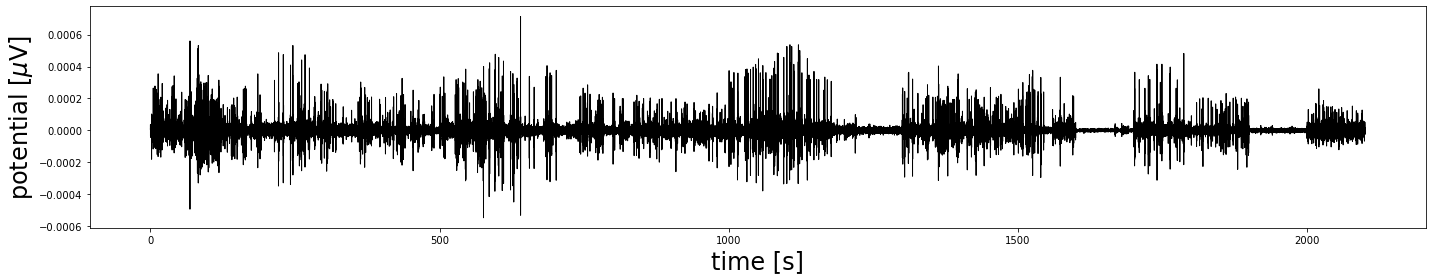

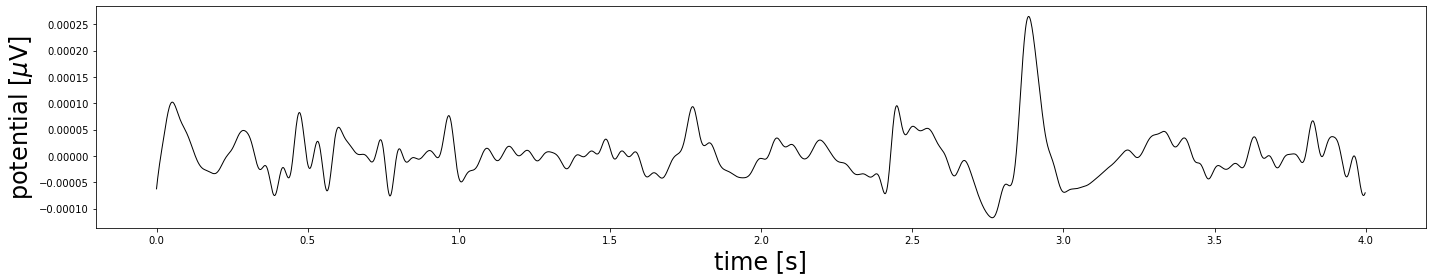

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 38501 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 20 iterations.
	K-means run 2/5 converged after 17 iterations.
	K-means run 3/5 converged after 46 iterations.
	K-means run 4/5 converged after 39 iterations.
	K-means run 5/5 converged after 20 iterations.
[+] Computation time: 7.50 sec

[+] Microstate back-fitting:
data_norm:  (1050105, 64)
data_cluster_norm:  (38501, 64)
maps:  (4, 64)

[+] Global explained variance GEV = 0.697
GEV_0: 0.047
GEV_1: 0.067
GEV_2: 0.060
GEV_3: 0.524

Empirical symbol distribution (RTT):

p_0 = 0.260
p_1 = 0.229
p_2 = 0.232
p_3 = 0.278

Empirical transition matrix:

|0.9170.0290.0310.023|
|0.0330.9030.0420.022|
|0.0340.0410.9020.022|
|0.0210.0190.0190.941|

GFP peaks per sec.: 18.33

Global explained variance (GEV) per map:
GEV(ms-0) = 0.05
GEV(ms-1) = 0.07
GEV(ms-2) = 0.06
GEV(ms-3) = 0.52

total GEV: 0.697

Empirical entropy H = 1.38 (ma

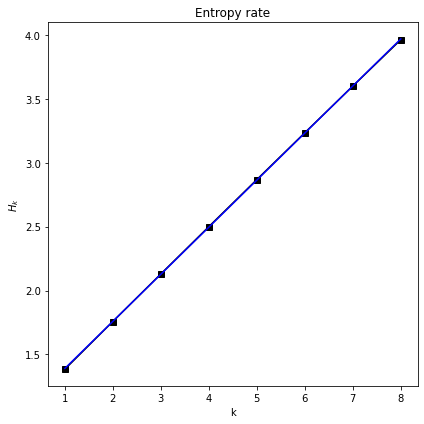


Empirical entropy rate h = 0.37
Theoretical MC entropy rate h = 0.37


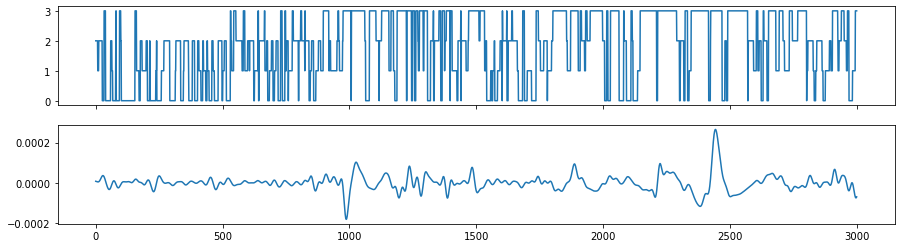

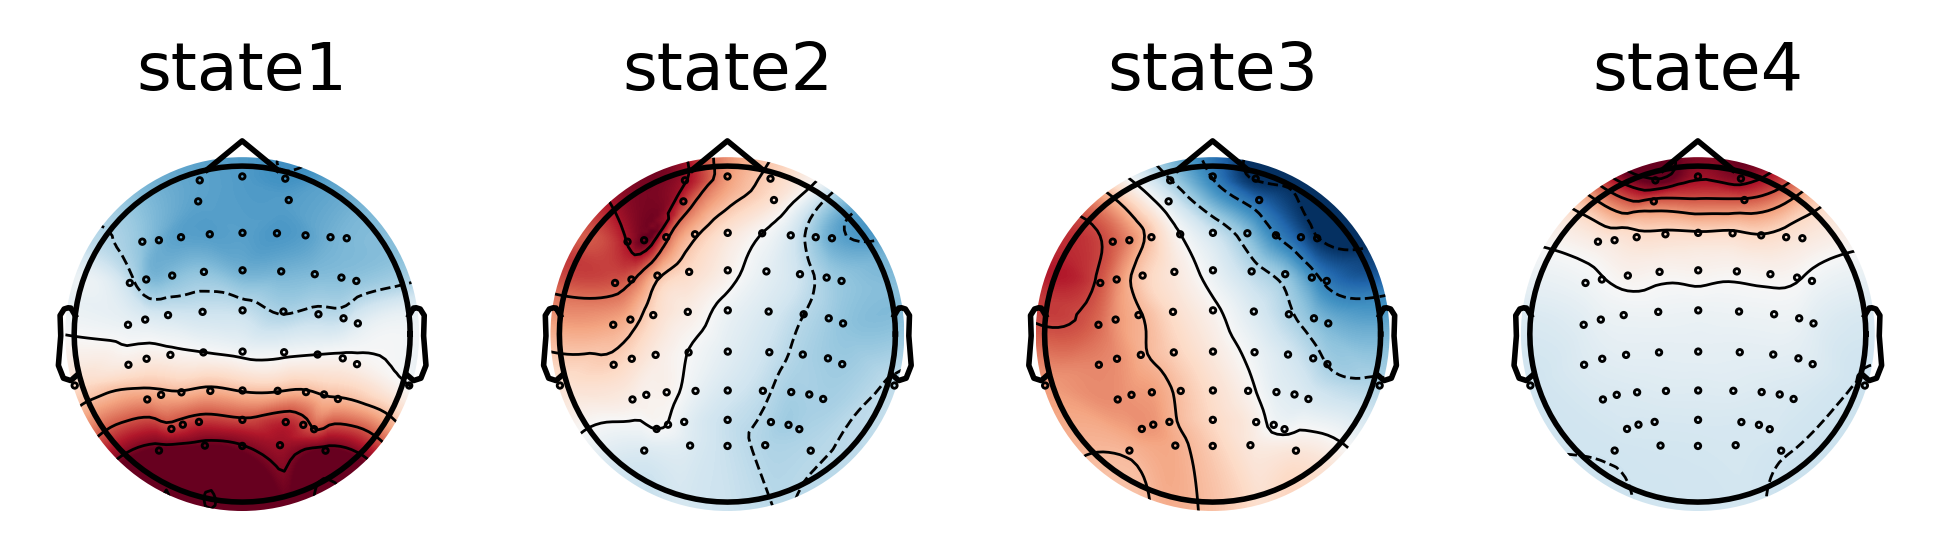

In [4]:
display_maps(epoch_4R, n_maps=4, save=True, dpi=400, filename='40Hz_rest',
fmt='.png', to_save_cache=True, time_augs=time_augs, tm=tm)

(1020102, 64)


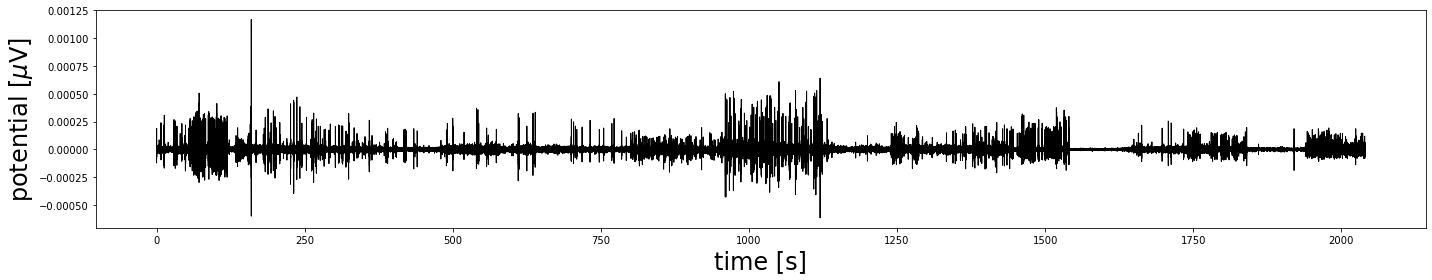

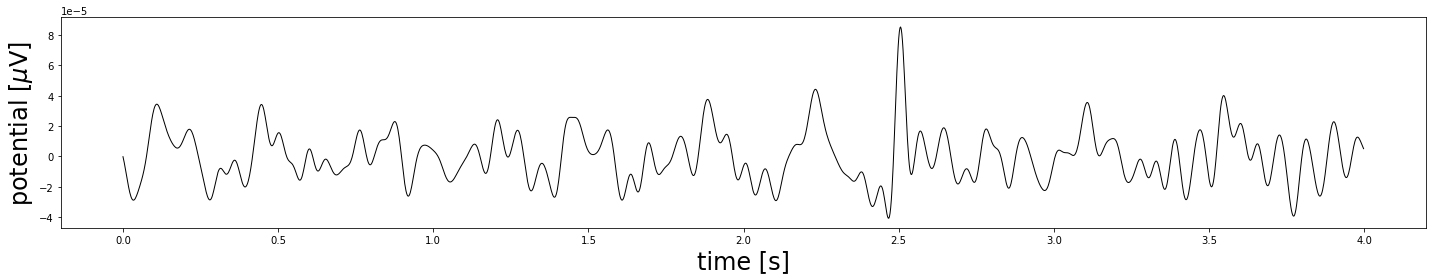

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 39216 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 15 iterations.
	K-means run 2/5 converged after 51 iterations.
	K-means run 3/5 converged after 29 iterations.
	K-means run 4/5 converged after 17 iterations.
	K-means run 5/5 converged after 22 iterations.
[+] Computation time: 7.27 sec

[+] Microstate back-fitting:
data_norm:  (1020102, 64)
data_cluster_norm:  (39216, 64)
maps:  (4, 64)

[+] Global explained variance GEV = 0.733
GEV_0: 0.563
GEV_1: 0.068
GEV_2: 0.045
GEV_3: 0.056

Empirical symbol distribution (RTT):

p_0 = 0.238
p_1 = 0.208
p_2 = 0.281
p_3 = 0.273

Empirical transition matrix:

|0.9390.0190.0230.019|
|0.0240.8950.0430.038|
|0.0170.0330.9100.039|
|0.0170.0290.0400.914|

GFP peaks per sec.: 19.22

Global explained variance (GEV) per map:
GEV(ms-0) = 0.56
GEV(ms-1) = 0.07
GEV(ms-2) = 0.05
GEV(ms-3) = 0.06

total GEV: 0.733

Empirical entropy H = 1.38 (ma

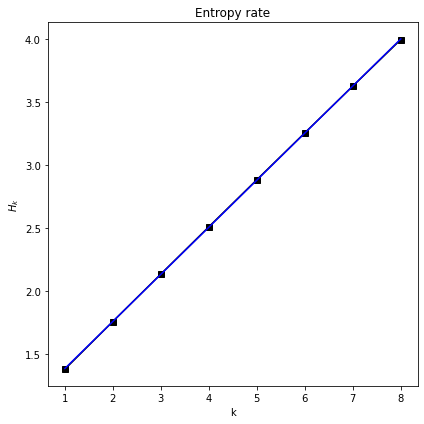


Empirical entropy rate h = 0.37
Theoretical MC entropy rate h = 0.38


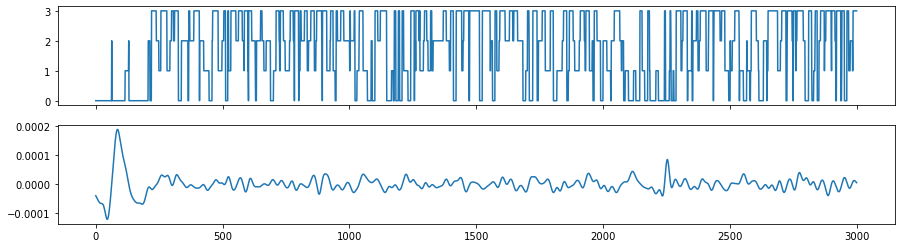

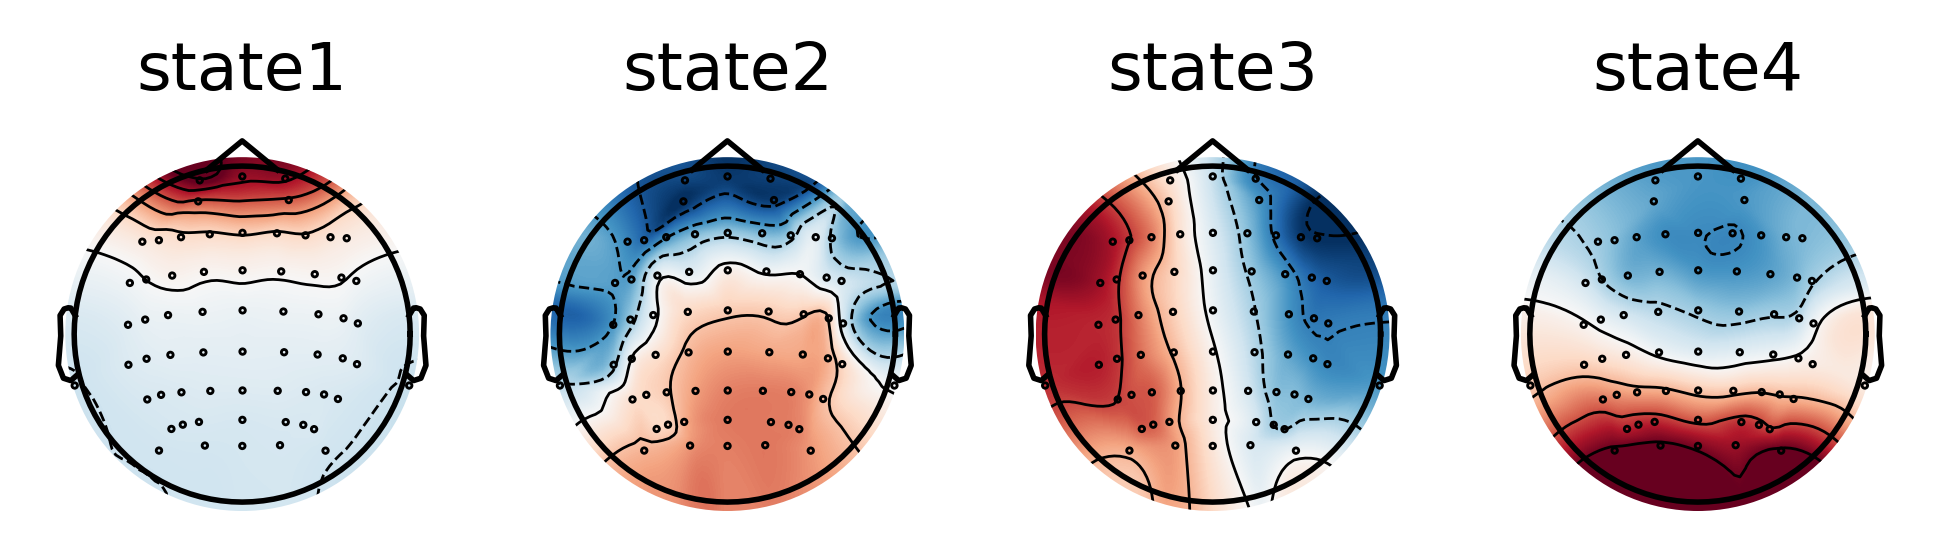

In [5]:
display_maps(epoch_4F, n_maps=4, save=True, dpi=400, filename='40Hz_flicker', 
fmt='.png', to_save_cache=True, time_augs=time_augs, tm=tm)

(237595, 64)


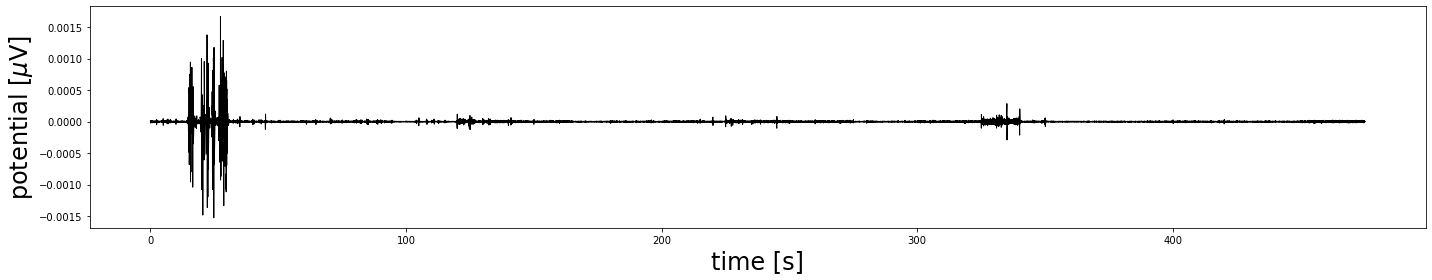

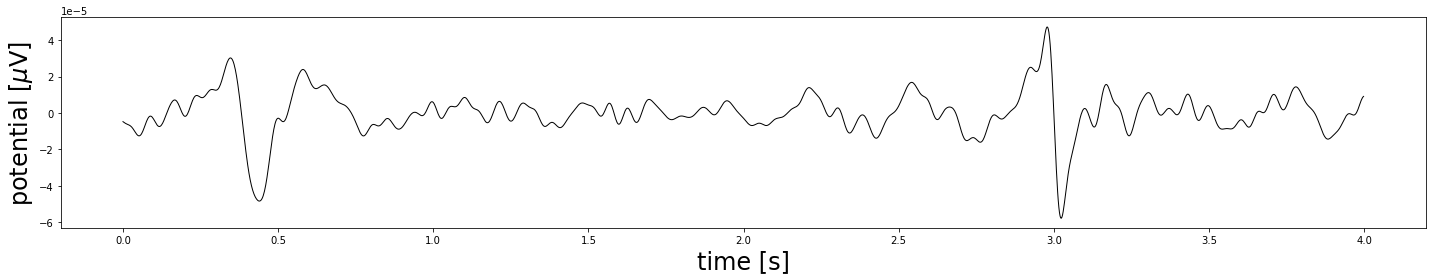

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 9176 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 12 iterations.
	K-means run 2/5 converged after 24 iterations.
	K-means run 3/5 converged after 13 iterations.
	K-means run 4/5 converged after 13 iterations.
	K-means run 5/5 converged after 8 iterations.
[+] Computation time: 1.51 sec

[+] Microstate back-fitting:
data_norm:  (237595, 64)
data_cluster_norm:  (9176, 64)
maps:  (4, 64)

[+] Global explained variance GEV = 0.737
GEV_0: 0.151
GEV_1: 0.164
GEV_2: 0.392
GEV_3: 0.029

Empirical symbol distribution (RTT):

p_0 = 0.025
p_1 = 0.642
p_2 = 0.111
p_3 = 0.222

Empirical transition matrix:

|0.8250.0910.0350.049|
|0.0040.9570.0140.025|
|0.0080.0810.8640.046|
|0.0050.0720.0240.899|

GFP peaks per sec.: 19.31

Global explained variance (GEV) per map:
GEV(ms-0) = 0.15
GEV(ms-1) = 0.16
GEV(ms-2) = 0.39
GEV(ms-3) = 0.03

total GEV: 0.737

Empirical entropy H = 0.95 (max. e

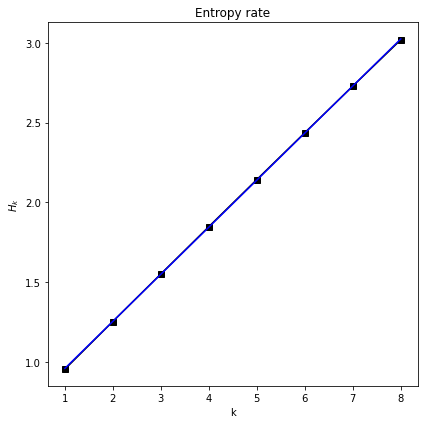


Empirical entropy rate h = 0.30
Theoretical MC entropy rate h = 0.30


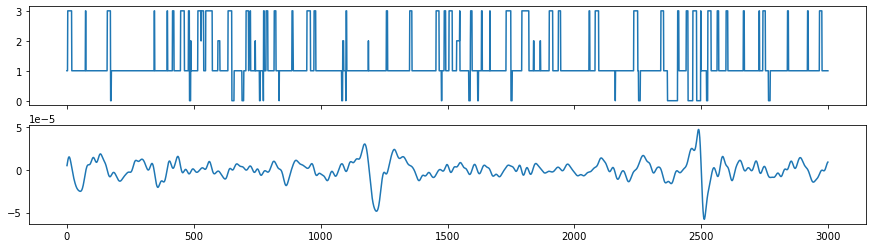

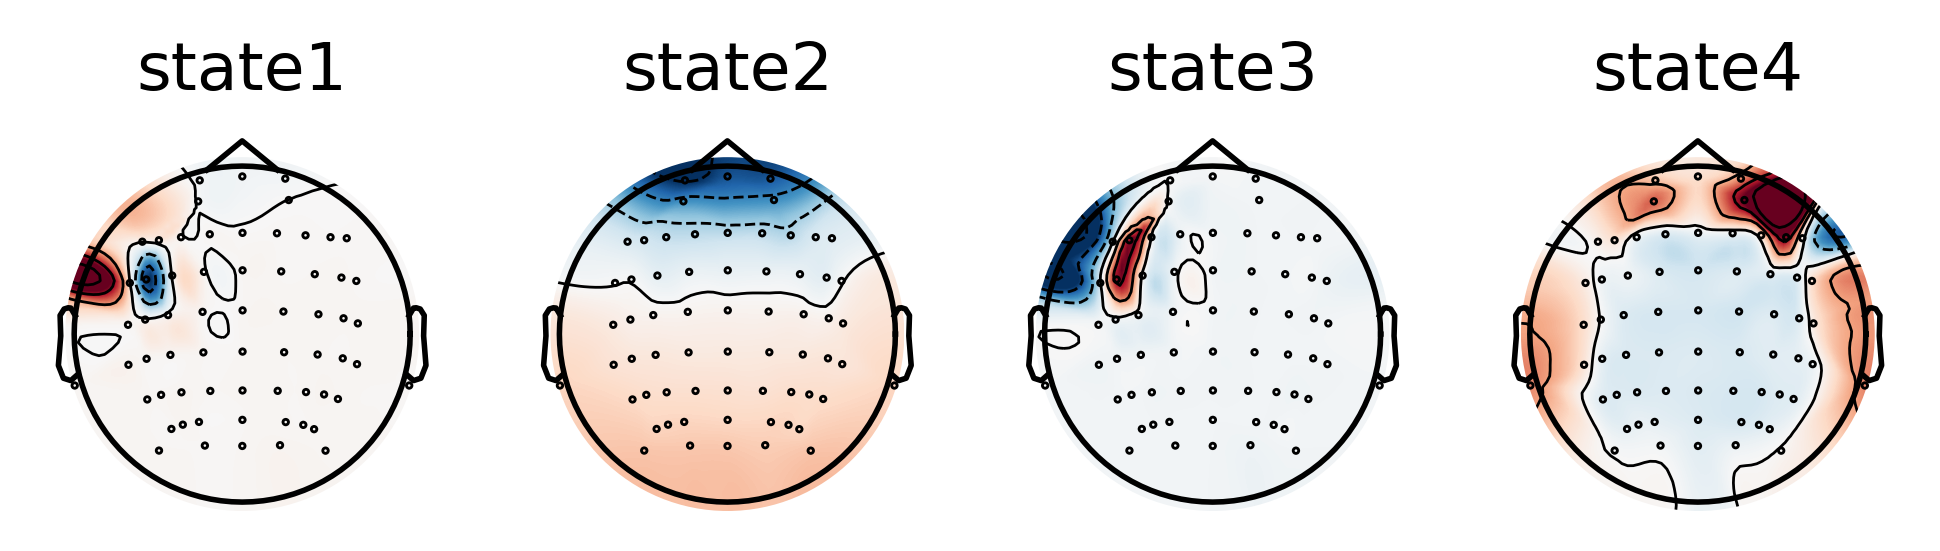

In [6]:
display_maps(epoch_RF, n_maps=4, save=True, dpi=400, filename='Random_flicker', 
fmt='.png', to_save_cache=True, time_augs=time_augs, tm=tm)